<a href="https://colab.research.google.com/github/Huang-Yongzhi/musiclm-pytorch/blob/main/musiclm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

如果重新运行，需要重启，不然trainer会报错，认为有多个实例

In [2]:
# 重启也要运行
!pip install musiclm-pytorch
!pip install --upgrade tensorflow tensorflow-io
!pip install audiolm_pytorch

  Obtaining dependency information for musiclm-pytorch from https://files.pythonhosted.org/packages/b3/da/20c86133f49aeb634ada68b66f5516e81bcf1de9dc9b3e3c37989ba18a23/musiclm_pytorch-0.2.8-py3-none-any.whl.metadata
  Obtaining dependency information for audiolm-pytorch>=0.17.0 from https://files.pythonhosted.org/packages/07/08/4f3a45f1a2b62cdd833c6f9000d2733307488972e6521a9ac42bef86b5b4/audiolm_pytorch-1.7.6-py3-none-any.whl.metadata
  Obtaining dependency information for beartype from https://files.pythonhosted.org/packages/46/8a/a90fe78c73958340ed6b6ab128a10598ad5f0ff57537ad17f6ccd1ad830b/beartype-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for einops>=0.6 from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for vector-quantize-pytorch>=1.0.0 from https://files.pythonhosted.org/packages/d1/4f/6ea0f03cff25ff0bd4743006890834a71e253

In [ ]:
!pip install you-get
!sudo apt-get install ffmpeg

# Usage
`MuLaN` first needs to be trained

In [3]:
# 重启也要运行

import array
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy
import soundfile
from scipy.io.wavfile import read
import torch
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer
import os
import pathlib
import numpy
import pandas
from musiclm_pytorch import MuLaNEmbedQuantizer


2023-11-13 04:17:40.340533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 04:17:40.340607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 04:17:40.340664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 验证环境
如果没有CUDA环境，就要将后面的.cuda()去掉

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# 加载三个transformer
`**MusicLM**` 用了三个transformer，`MuLan(Audio)`, `w2v-BERT`, `SoundStream`
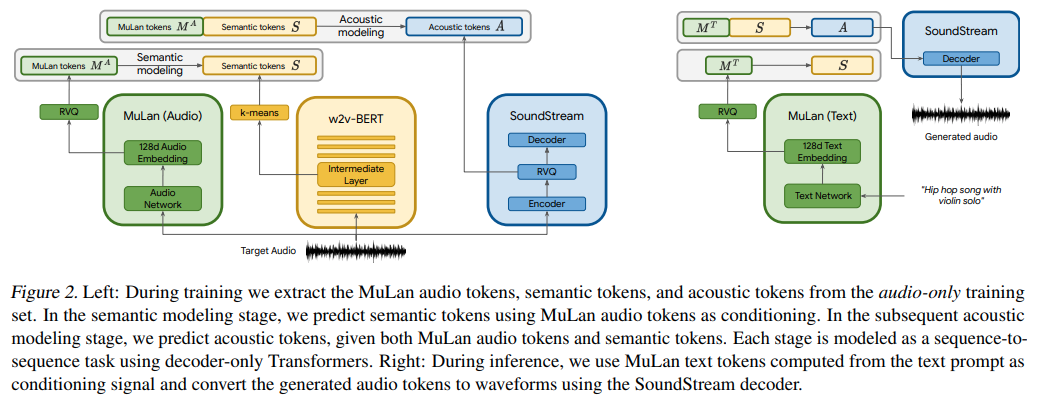

**声学模块SoundStream**：端到端神经音频编解码器，能提供更高质量的音频，并扩展至编码不同的声音类型

**语义模块w2v-BERT**：使用该模型的掩码语言建模(MLM)模块的中间层。在预训练和冻结模型之后，从第7层提取embedding，并使用学习到的k-means质心对embedding进行量化。该模块主要起到提取语义词元的作用

**音频文本对MuLan**：采用双塔并行编码器架构，使用对比损失进行训练，在音乐音频和文本之间形成共享嵌入空间。即`音频信号和文本语义都具有基于离散标记的同质表示`


In [ ]:
# 重启也要运行
import torch
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer

audio_transformer = AudioSpectrogramTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64,
    spec_n_fft = 128,
    spec_win_length = 24,
    spec_aug_stretch_factor = 0.8
)

text_transformer = TextTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64
)

mulan = MuLaN(
    audio_transformer = audio_transformer,
    text_transformer = text_transformer
)

# get a ton of <sound, text> pairs and train

wavs = torch.randn(2, 1024)
texts = torch.randint(0, 20000, (2, 256))

loss = mulan(wavs, texts)
loss.backward()

# after much training, you can embed sounds and text into a joint embedding space
# for conditioning the audio LM

embeds = mulan.get_audio_latents(wavs)  # during training

embeds = mulan.get_text_latents(texts)  # during inference

To obtain the conditioning embeddings for the three transformers that are a part of AudioLM, you must use the `MuLaNEmbedQuantizer` as so

# MusicLM

In [ ]:
# 重启也要运行
from musiclm_pytorch import MuLaNEmbedQuantizer

# setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

quantizer = MuLaNEmbedQuantizer(
    mulan = mulan,                          # pass in trained mulan from above
    conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
    namespaces = ('semantic', 'coarse', 'fine')
)

# now say you want the conditioning embeddings for semantic transformer

wavs = torch.randn(2, 1024)
conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers

# 加载数据集

1.数据集内容

调用的.csv文件内容如下
```
ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']","The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",4,False,True
...
```

**解释**：
数据集是一个包含音频信息和描述的元数据文件，格式类似于 CSV。每行包含一个 YouTube 音频的标识符（ytid），音频的开始和结束时间（start_s 和 end_s），音频标签（audioset_positive_labels）和其他相关信息。

使用如 youtube-dl 这类工具来下载视频，然后使用音频处理库（例如 librosa 或 pydub）来裁剪音频。以下是一个大致的步骤指南：

# 1. 使用 youtube-dl
下载 YouTube 音频
首先，您需要安装 youtube-dl。在 Colab 中，您可以使用以下命令安装：

In [ ]:
# !pip install youtube-dl


In [ ]:
# !pip install --upgrade youtube-dl


In [ ]:
# import librosa
# import soundfile as sf
# import os
# import pandas as pd
# from youtube_dl import YoutubeDL

# def trim_audio(file_path, start_time, end_time, output_path):
#     y, sr = librosa.load(file_path, sr=None, offset=start_time, duration=end_time - start_time)
#     sf.write(output_path, y, sr)

# def download_youtube_audio(ytid, output_dir):
#     ydl_opts = {
#         'format': 'bestaudio/best',
#         'postprocessors': [{
#             'key': 'FFmpegExtractAudio',
#             'preferredcodec': 'wav',
#             'preferredquality': '192',

#         }],
#         'verbose': True,
#         'outtmpl': os.path.join(output_dir, '%(id)s.%(ext)s')
#     }

#     try:
#         with YoutubeDL(ydl_opts) as ydl:
#             ydl.download([f'http://www.youtube.com/watch?v={ytid}'])
#     except Exception as e:
#         print(f"Error downloading video {ytid}: {e}")
#         return False  # Indicate failure
#     return True  # Indicate success


# # 加载CSV文件
# csv_file = 'musiccaps-public.csv'
# df = pd.read_csv(csv_file)

# # 遍历CSV文件，下载并裁剪音频
# for index, row in df.iterrows():
#     ytid = row['ytid']
#     start_s = row['start_s']
#     end_s = row['end_s']
#     if download_youtube_audio(ytid, 'downloaded_audios'):
#         try:
#             trim_audio(f'downloaded_audios/{ytid}.wav', start_s, end_s, f'trimmed_audios/{ytid}.wav')
#         except Exception as e:
#             print(f"Error trimming audio for video {ytid}: {e}")

# 2. 使用Youtube-dl会报错
改用you-get

In [ ]:
# !pip install you-get

测试一下You-Get

In [ ]:
# !you-get -i 'https://www.youtube.com/watch?v=jNQXAC9IVRw'

检查可用格式：运行 you-get 命令带 -i 选项（用于信息查看模式），查看该视频支持的所有可用格式。这样可以帮助您了解是否有特定的音频格式可供下载。执行命令如下：

In [ ]:
!you-get -i "https://www.youtube.com/watch?v=-0Gj8-vB1q4"


In [ ]:
!you-get --no-caption -o "./downloaded_videos" --itag=160 "https://www.youtube.com/watch?v=-0Gj8-vB1q4"


# 3. 提取音频
安装**ffmpeg** 或其他类似工具来从下载的视频文件中提取音频。

In [ ]:
# !sudo apt-get install ffmpeg


## 使用无损编码器
编解码器是 aac，这是 .m4a 文件的典型编解码器。

要生成 .wav 文件，应该使用无损的编解码器（例如，pcm_s16le）

In [ ]:
import subprocess
import librosa
import soundfile as sf
import os
import pandas as pd
import glob # 用于文件路径名的模式匹配
from datetime import datetime

# def trim_audio(file_path, start_time, end_time, output_path):
#     y, sr = librosa.load(file_path, sr=None, offset=start_time, duration=end_time - start_time)
#     sf.write(output_path, y, sr)




# def download_lowest_resolution_video(ytid, video_output_dir):
#     video_url = f'https://www.youtube.com/watch?v={ytid}'
#     try:
#         # 使用 you-get 下载分辨率最低的视频
#         subprocess.run(['you-get', '--no-caption', '-o', video_output_dir, '--itag=160', video_url], check=True)
#     except subprocess.CalledProcessError as e:
#         print(f"Error downloading video {ytid}: {e}")
#         return False  # Indicate failure
#     return True  # Indicate success


def get_latest_file_in_dir(directory):
    """ 获取指定目录中最新的文件 """
    list_of_files = glob.glob(os.path.join(directory, '*'))
    if not list_of_files:  # 如果目录为空
        return None
    latest_file = max(list_of_files, key=os.path.getmtime)
    return latest_file



def download_lowest_resolution_video(ytid, video_output_dir):
    video_url = f'https://www.youtube.com/watch?v={ytid}'
    try:
      # 使用 you-get 下载分辨率最低的视频
        subprocess.run(['you-get', '--no-caption', '-o', video_output_dir, '--itag=160', video_url], check=True)
        print (f"Download {ytid} video.")
    except subprocess.CalledProcessError as e:
        print(f"Error downloading video {ytid}: {e}")
        return None
    # 查找下载的视频文件
    return get_latest_file_in_dir(video_output_dir)



def extract_audio_from_video(video_path, output_audio_path):
    try:
        result = subprocess.run(['ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le', output_audio_path], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        file_name = video_path.split('/')[-1]
        print (f"Extract {file_name} video.")
    except subprocess.CalledProcessError as e:
        print(f"Error extracting audio from video {video_path}: {e}\nOutput: {e.stdout.decode()}\nError: {e.stderr.decode()}")





# 加载CSV文件
csv_file = '/kaggle/input/musiccaps/musiccaps-public.csv' # musiccaps-public.csv
df = pd.read_csv(csv_file)

video_output_dir = './downloaded_videos' # .downloaded_videos
audio_output_dir = './downloaded_audios' # ./downloaded_audios

# 确保输出目录存在
os.makedirs(video_output_dir, exist_ok=True)
os.makedirs(audio_output_dir, exist_ok=True)

test_n = 0
# 遍历CSV文件，下载视频并提取音频
for index, row in df.iterrows():
  if test_n >= 3:
    break
  ytid = row['ytid']
  downloaded_video = download_lowest_resolution_video(ytid, video_output_dir) # 下载视频
  if downloaded_video:
    # video_path = os.path.join(video_output_dir, f'{ytid}.mp4')  # 假设视频文件扩展名为 .mp4，命名可能不成功
#     audio_path = os.path.join(audio_output_dir, f'{ytid}.m4a')   # 输出音频文件为 .m4a
    audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')   # 输出音频文件为 .wav
    extract_audio_from_video(downloaded_video, audio_path)
  test_n += 1

# 3.下载训练模型的文件内容

hubert_base_ls960.pt 文件是一个预训练的模型权重文件，用于 **HuBERT （Hidden Unit BERT）模型**。HuBERT 是由Facebook AI 研究团队开发的一种**自监督学习的语音识别模型**。它是基于 BERT 架构的，专门针对语音处理任务进行了优化。

In [ ]:
import requests

def download_file(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # 检查请求是否成功

    with open(filename, 'wb') as f:
        f.write(response.content)

# 设置文件的URL和你想要保存的文件名
file_url = "https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960.pt"
file_name = "hubert_base_ls960.pt"

# 下载文件
download_file(file_url, file_name)

# 设置文件的URL和你想要保存的文件名
file_url = "https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960_L9_km500.bin"
file_name = "hubert_base_ls960_L9_km500.bin"

# 下载文件
download_file(file_url, file_name)



SemanticTransformerTrainer（这可能是一个音频处理或自然语言处理相关的训练器）

In [ ]:
# 不是我们要的音频链接
# import requests

# url = "https://github.com/hsfzxjy/models.storage/releases/download/HRNet-OCR/hrnet_cs_8090_torch11.pth"
# response = requests.get(url)
# response.raise_for_status()

# file_name = url.split('/')[-1]

# with open(file_name, 'wb') as f:
#   f.write(response.content)






# 5.train Hubert模型，audioLM transformer training
To train (or finetune) the three transformers that are a part of `AudioLM`, you simply follow the instructions over at `audiolm-pytorch` for training, but pass in the `MulanEmbedQuantizer` instance to the training classes under the keyword `audio_conditioner`

ex. `SemanticTransformerTrainer`

验证路径是否正确

In [ ]:
import os
print("Current working directory:", os.getcwd())
print("Files in './downloaded_audios':", os.listdir('./downloaded_audios'))


每次注释掉一个transformer，然后重启运行

In [ ]:

# import torch
# from audiolm_pytorch import HubertWithKmeans, SemanticTransformer, SemanticTransformerTrainer

# wav2vec = HubertWithKmeans(
#     checkpoint_path = 'hubert_base_ls960.pt',
#     kmeans_path = 'hubert_base_ls960_L9_km500.bin'
# )


# semantic_transformer = SemanticTransformer(
#     num_semantic_tokens = wav2vec.codebook_size,
#     dim = 1024,
#     depth = 6,
#     audio_text_condition = True      # this must be set to True (same for CoarseTransformer and FineTransformers)
# ).cuda()

# trainer = SemanticTransformerTrainer(
#     transformer = semantic_transformer,
#     wav2vec = wav2vec,
#     audio_conditioner = quantizer,   # pass in the MulanEmbedQuantizer instance above
#     folder ='./downloaded_audios',
#     batch_size = 1,
#     data_max_length = 320 * 32,
#     num_train_steps = 1
# )

# trainer.train()
# torch.save(semantic_transformer.state_dict(), 'semantic_transformer.pth') # 保存模型
# # del trainer  # 显式删除实例，删除好像没有效果，需要存下来重启

# **重启后**，重新创建 semantic_transformer 实例

In [ ]:
# 重启也要运行
# 重启后导入必要的库
import torch
from audiolm_pytorch import HubertWithKmeans, SemanticTransformer, AudioLM

# 重新创建和初始化模型
wav2vec = HubertWithKmeans(
    checkpoint_path='hubert_base_ls960.pt', 
    kmeans_path='hubert_base_ls960_L9_km500.bin'
)
semantic_transformer = SemanticTransformer(
    num_semantic_tokens=wav2vec.codebook_size, 
    dim=1024, depth=6, 
    audio_text_condition=True).cuda()

# 加载之前保存的模型状态
semantic_transformer.load_state_dict(torch.load('semantic_transformer.pth'))

# 6. train AudioLM

In [ ]:
# import torch
# from unittest import mock
# from audiolm_pytorch import SoundStream, CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, MusicLMSoundStream

# # soundstream = SoundStream.init_and_load_from('/path/to/trained/soundstream.pt')
# soundstream = MusicLMSoundStream() 

# coarse_transformer = CoarseTransformer(
#     num_semantic_tokens = wav2vec.codebook_size,
#     codebook_size = 1024,
#     num_coarse_quantizers = 4,
#     dim = 1024,
#     depth = 6,
#     audio_text_condition = True
# ).cuda()

# with mock.patch('builtins.input', return_value='n'):
#     trainer = CoarseTransformerTrainer(
#         transformer = coarse_transformer,
#         codec = soundstream,
#         wav2vec = wav2vec,
#         audio_conditioner = quantizer,
#         folder = './downloaded_audios/',
#         batch_size = 1,
#         data_max_length = 320 * 32,
#         num_train_steps = 1
#     )
#     trainer.train()
#     # 保存模型状态字典
#     torch.save(coarse_transformer.state_dict(), 'coarse_transformer.pth') # 保存模型

    

# **重启后**，重新创建 coarse_transformer 实例

In [ ]:
# 重启也要运行
import torch
from audiolm_pytorch import CoarseTransformer, AudioLMSoundStream

# 重新创建模型架构
coarse_transformer = CoarseTransformer(
    num_semantic_tokens = wav2vec.codebook_size,
    codebook_size = 1024,
    num_coarse_quantizers = 4,
    dim = 1024,
    depth = 6,
    audio_text_condition = True
).cuda()

# 加载之前保存的状态字典
coarse_transformer.load_state_dict(torch.load('coarse_transformer.pth')) 


In [13]:
# import torch
# from unittest import mock
# from audiolm_pytorch import SoundStream, FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, MusicLMSoundStream

# # soundstream = SoundStream.init_and_load_from('/path/to/trained/soundstream.pt')
# soundstream = MusicLMSoundStream() 

# fine_transformer = FineTransformer(
#     num_coarse_quantizers = 4,
#     num_fine_quantizers = 8,
#     codebook_size = 1024,
#     dim = 1024,
#     depth = 6,
#     audio_text_condition = True
# ).cuda()

# with mock.patch('builtins.input', return_value='n'):
#     trainer = FineTransformerTrainer(
#         transformer = fine_transformer,
#         codec = soundstream,
#         folder = './downloaded_audios/',
#         batch_size = 1,
#         data_max_length = 320 * 32,
#         num_train_steps = 1,
#         audio_conditioner = quantizer
#     )

#     trainer.train()
#     torch.save(fine_transformer.state_dict(), 'fine_transformer.pth') # 保存模型

training with dataset of 2 samples and validating with randomly splitted 1 samples
0: loss: 113.2735824584961
0: valid loss 10.966878890991211
0: saving model to results
training complete


# **重启后**，重新创建 fine_transformer 实例

In [ ]:
# 重启也要运行
import torch
from audiolm_pytorch import CoarseTransformer, AudioLMSoundStream

# 重新创建模型架构
fine_transformer = FineTransformer(
    num_coarse_quantizers = 4,
    num_fine_quantizers = 8,
    codebook_size = 1024,
    dim = 1024,
    depth = 6,
    audio_text_condition = True
).cuda()

# 加载之前保存的状态字典
fine_transformer.load_state_dict(torch.load('fine_transformer.pth')) 


In [ ]:
from audiolm_pytorch import AudioLM


audiolm = AudioLM(
    wav2vec = wav2vec,
    codec = soundstream,
    semantic_transformer = semantic_transformer,
    coarse_transformer = coarse_transformer,
    fine_transformer = fine_transformer
)

# 7. musiclm

In [ ]:
# you need the trained AudioLM (audio_lm) from above
# with the MulanEmbedQuantizer (mulan_embed_quantizer)

from musiclm_pytorch import MusicLM

musiclm = MusicLM(
    audio_lm = audiolm,
    mulan_embed_quantizer = quantizer
).cuda()

music = musiclm('the crystalline sounds of the piano in a ballroom', num_samples = 1) # sample 4 and pick the top match with mulan

In [ ]:
torch.save(music, 'generated_music.pt')

In [ ]:
output_path = "out.wav"
sample_rate = 44100
torchaudio.save(output_path, music.cpu() , sample_rate)